### GPT 3.5 Evaluation

Here, we run the GPT 3.5 Turbo model hosted by OpenAI via our own Google Cloud Function to evaluate its performance in outputing General and Temporal labels on the same test-set of 1287 claim and evidence pairs that was used for the LSTM model.

We could have used the text-davinci completions model available by OpenAI. However, cost was prohibitive and we relied on the GPT 3.5 Turbo model that is 1/10 the cost of Da-Vinci, but requires some serious prompt engineering to fine-tune.

Cost:

| Model             | Usage              |
| ------------------| -------------------|
| **gpt-3.5-turbo**     | **USD 0.002** / 1K tokens | 
| **text-davinci-003**  | **USD 0.02** / 1K tokens  |


Based on the 1287 claim and evidence pairs that we used, gpt-3.5 would have cost us 2.574 USD while text-davinci-003 would have been 10 times more at 25.74 USD.

The final prompt that was used is reflected below:

You are provided with a claim and evidence sentence, each of which is a string of text. Perform text classification to determine whether the evidence might support, refute, or not have enough information on the claim. Ignore irrelevant elements of the evidence. Please return the following information in JSON format: 
* SAME_ENTITY_LABEL: A boolean value indicating whether the main subject of the claim and evidence refer to the same entity. An entity can be a person, place, or thing. If the claim and evidence refer to the same entity, even if there are coreferences that make it unclear, the SAME_ENTITY_LABEL should be true.
* SAME_ENTITY_JUSTIFICATION: A brief justification for your SAME_ENTITY_LABEL. * GENERAL_FACTS_LABEL: Either "SUPPORTS", "REFUTES", or "NOT ENOUGH INFO" indicating whether the the non-temporal information in the evidence supports, refutes, or has not enough information to address the claim.
*GENERAL_FACTS_JUSTIFICATION: An explanation of which part of the evidence supports, refutes, or provides insufficient information for the claim in terms of non-temporal information. If the evidence does not address all aspects of the claim, mention that fact and provide an explanation for why the evidence is insufficient.
* TIME_LABEL: Either 'SUPPORTS', 'REFUTES', or 'NOT ENOUGH INFO' indicating whether the date or time information in the evidence matches the date or time stated in the claim, ignoring general facts.
* TIME_JUSTIFICATION: An explanation for the TIME_LABEL decision based on the date or time information present in the evidence and claim. 
* TOPIC: The most likely topic that the claim and evidence is referring to. If the claim and evidence are referring to entirely different topics, then return both topics separately.

In [1]:
import pandas as pd
# Read in full file
processed = pd.read_csv("test_df.csv")
processed

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,temporal_claim,temporal_evidence,claim_numbers,evidence_numbers,all_entities_similarity,all_chunks_similarity,named_entities_similarity,temporal_similarity,count_claim_numbers,count_evidence_numbers
0,58219,Theodore Roosevelt was born in 1919.,REFUTES,REFUTES,['in 1919'],Theodore_Roosevelt,"In foreign policy , he focused on Central Amer...",Theodore Roosevelt was born in 1919.,"In foreign policy, he focused on Central Ameri...","['Theodore Roosevelt', '1919']",...,['1919'],[],[],[],0.090278,0.125000,0.091334,0.000000,0,0
1,50432,Bill Gates had a career at Microsoft after hel...,SUPPORTS,SUPPORTS,['after helping to found the company'],Bill_Gates,"In June 2006 , Gates announced that he would b...",Bill Gates had a career at Microsoft after hel...,"In June 2006, Gates announced that he would be...","['Bill Gates', 'Microsoft']",...,[],['june 2006'],[],[],0.500000,0.479960,0.500000,0.000000,0,0
2,58993,Snoop Dog's Doggystyle sold many copies in the...,SUPPORTS,NOT ENOUGH INFO,['in the first week of its release'],Doggystyle,Doggystyle is the debut studio album by Americ...,Snoop Dog s Doggystyle sold many copies in the...,Doggystyle is the debut studio album by Americ...,"['Snoop Dog s Doggystyle', 'the first week']",...,['the first week'],[],[],[],0.356250,0.329576,0.241071,0.000000,0,0
3,19794,"In 1899, FC Barcelona was formed.",SUPPORTS,NOT ENOUGH INFO,['In 1899'],FC_Barcelona,Barcelona was ranked first in the IFFHS Club W...,"In 1899, FC Barcelona was formed.",Barcelona was ranked first in the IFFHS Club W...,"['1899', 'Barcelona']",...,['1899'],"['2009', '2015', 'currently', '1997', '2012', ...",[],[],0.500000,0.312500,0.443249,0.386497,0,0
4,10805,Independence Day: Resurgence grossed millions ...,SUPPORTS,NOT ENOUGH INFO,['Independence Day'],Independence_Day_-LRB-1996_film-RRB-,The film grossed over 817.4 million worldwide ...,Independence Day: Resurgence grossed millions ...,"The film grossed over 817.4 million worldwide,...","['Independence Day:', 'millions']",...,['independence day'],"['1996', '1993']",[],"['817.4', 'million']",0.332309,0.153477,0.332309,0.136918,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,28241,The Jacksons aired on a weekday.,SUPPORTS,SUPPORTS,['on a weekday'],The_Jacksons_-LRB-TV_series-RRB-,The thirty minute Wednesday evening show began...,The Jacksons aired on a weekday.,The thirty minute Wednesday evening show began...,['weekday'],...,[],"['the thirty minute wednesday evening', '1976 ...",[],['12'],0.000000,0.093750,0.321221,0.000000,0,1
1283,61561,"Iris Murdoch died on February 8, 1999.",SUPPORTS,SUPPORTS,"['on February 8 , 1999']",Iris_Murdoch,Dame Jean Iris Murdoch LRB LSB ˈmɜrdɒk RSB 15 ...,"Iris Murdoch died on February 8, 1999.",Dame Jean Iris Murdoch LRB LSB ˈmɜrdɒk RSB 15 ...,"['Iris Murdoch', 'February 8, 1999']",...,['february 8 1999'],['15 july 1919 8 february 1999'],[],['8'],0.500000,0.347619,0.580235,1.000000,0,1
1284,41237,"In the 1960's, George Tuska worked on Iron Man...",SUPPORTS,NOT ENOUGH INFO,"[""In the 1960 's""]",Iron_Man,The character made his first appearance in Tal...,"In the 1960 s, George Tuska worked on Iron Man...",The character made his first appearance in Tal...,"['1960', 'George Tuska', 'Iron Man']",...,['1960'],['march 1963'],[],['39'],0.108333,0.160461,0.273263,0.832981,0,1
1285,9697,Warm Leatherette is by an actress and it came ...,SUPPORTS,SUPPORTS,['in 1980'],Warm_Leatherette_-LRB-album-RRB-,Warm Leatherette is the fourth studio album by...,Warm Leatherette is by an actress and it came ...,Warm Leatherette is the fourth studio album by...,['1980'],...,['1980'],['9 may 1980'],[],[],0.000000,0.352722,1.000000,1.000000,0,0


In [2]:
# Api calls were made in batches to prevent overloading
import pandas as pd
import requests
import json

def call_openai_api(row):
    claim = row["processed_claim_some_punctuation"]
    evidence = row["processed_evidence_some_punctuation"]
    payload = {
        "claim": claim,
        "evidence": evidence
    }
    print(claim)
    print(evidence)
    try:
        response = requests.post("https://fyp-gpt-wr6verfzva-as.a.run.app", json=payload)
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(response)
            print(f"Request failed with status code {response.status_code}")
    except Exception as e:
        print(f"Request failed with exception {e}")
    return None

df = processed[400:]

# Call the OpenAI API for each row and store the results in a new column called 'openai_results'
df['openai_results'] = df.apply(call_openai_api, axis=1)

# Filter out the rows where the API call failed
df = df[df['openai_results'].notna()]

# Ignore the column labels, as they were generated in the wrong order, but the response is correct
# Create new columns in the dataframe for each field in the JSON response
df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic']] = df['openai_results'].apply(pd.Series)
df

Evan Rachel Wood started acting in the 1990s.
Wood continued acting mostly in independent films, including Pretty Persuasion LRB 2005 RRB, Down in the Valley LRB 2006 RRB, Running with Scissors LRB 2006 RRB, and in the big studio production Across the Universe LRB 2007 RRB.
The USS Constitution is closed to visitors 9 months out of the year.
As a fully commissioned U.S. Navy ship, her crew of 60 officers and sailors participate in ceremonies, educational programs, and special events while keeping Constitution open to visitors year round and providing free tours.
Sophie Turner finished college on February.
Turner has also starred in the television film The Thirteenth Tale LRB 2013 RRB and she made her feature film debut in Another Me LRB 2013 RRB.
Maria I of Portugal was born in a year other than 1734.
He would be proclaimed King of Portugal in the Battle of Ourique in 1139 and was recognised as such by neighbouring kingdoms in 1143.
Natalie Wood died of a heart attack at the age of 43.

/tmp/ipykernel_51/3384195076.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['openai_results'] = df.apply(call_openai_api, axis=1)
/tmp/ipykernel_51/3384195076.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic']] = df['openai_results'].apply(pd.Series)
/tmp/ipykernel_51/3384195076.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,count_claim_numbers,count_evidence_numbers,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic
400,50750,Evan Rachel Wood started acting in the 1990s.,SUPPORTS,NOT ENOUGH INFO,['in the 1990s'],Evan_Rachel_Wood,Wood continued acting mostly in independent fi...,Evan Rachel Wood started acting in the 1990s.,Wood continued acting mostly in independent fi...,"['Evan Rachel Wood', 'the 1990s']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides a list of films that Eva...,SUPPORTS,The claim and evidence both refer to Evan Rach...,True,The evidence mentions specific years when Evan...,SUPPORTS,Evan Rachel Wood's acting career
401,63933,The USS Constitution is closed to visitors 9 m...,REFUTES,REFUTES,['9 months out of the year'],USS_Constitution,"As a fully commissioned U.S. Navy ship , her c...",The USS Constitution is closed to visitors 9 m...,"As a fully commissioned U.S. Navy ship, her cr...","['The USS Constitution', '9 months', 'the year']",...,0,1,{'general_facts_justification': 'The evidence ...,The evidence states that the crew of the USS C...,SUPPORTS,"The evidence refers to the USS Constitution, w...",True,The evidence does not provide any specific dat...,NOT ENOUGH INFO,USS Constitution
402,67395,Sophie Turner finished college on February.,NOT ENOUGH INFO,NOT ENOUGH INFO,['on February'],Sophie_Turner,Turner has also starred in the television film...,Sophie Turner finished college on February.,Turner has also starred in the television film...,"['Sophie Turner', 'February']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence does not mention Sophie Turner's ...,False,The evidence mentions that Turner starred in a...,SUPPORTS,Sophie Turner's education
403,40542,Maria I of Portugal was born in a year other t...,REFUTES,NOT ENOUGH INFO,['in a year other than 1734'],Portugal,He would be proclaimed King of Portugal in the...,Maria I of Portugal was born in a year other t...,He would be proclaimed King of Portugal in the...,"['Maria', 'Portugal', 'a year other than 1734']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence talks about a king of Portugal in...,False,The evidence talks about a battle in 1139 and ...,REFUTES,Portuguese history
404,5249,Natalie Wood died of a heart attack at the age...,NOT ENOUGH INFO,NOT ENOUGH INFO,['at the age of 43'],Natalie_Wood,Natalie Wood LRB born Natalia Nikolaevna Zakha...,Natalie Wood died of a heart attack at the age...,Natalie Wood LRB born Natalia Nikolaevna Zakha...,"['Natalie Wood', 'the age of 43']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides information about Natali...,SUPPORTS,The claim and evidence both refer to Natalie W...,True,The evidence mentions that Natalie Wood was bo...,SUPPORTS,Natalie Wood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,28241,The Jacksons aired on a weekday.,SUPPORTS,SUPPORTS,['on a weekday'],The_Jacksons_-LRB-TV_series-RRB-,The thirty minute Wednesday evening show began...,The Jacksons aired on a weekday.,The thirty minute Wednesday evening show began...,['weekday'],...,0,1,{'general_facts_justification': 'The evidence ...,The evidence mentions that the show aired on a...,SUPPORTS,The evidence mentions 'The Jacksons' and the c...,True,The evidence mentions that the show aired duri...,SUPPORTS,Television show
1283,61561,"Iris Murdoch died on February 8, 1999.",SUPPORTS,SUPPORTS,"['on February 8 , 1999']",Iris_Murdoch,Dame Jean Iris Murdoch LRB LSB ˈmɜrdɒk RSB 15 ...,"Iris Murdoch died on February 8, 1999.",Dame J

In [3]:
# Concat results every time they are available
new_df = pd.read_csv("GPT_Results.csv")
resultsdf = pd.concat([df, new_df]).drop_duplicates(subset=['processed_claim_some_punctuation', 'processed_evidence_some_punctuation'])
print(len(resultsdf))
resultsdf

1262


,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,count_claim_numbers,count_evidence_numbers,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic
400,50750,Evan Rachel Wood started acting in the 1990s.,SUPPORTS,NOT ENOUGH INFO,['in the 1990s'],Evan_Rachel_Wood,Wood continued acting mostly in independent fi...,Evan Rachel Wood started acting in the 1990s.,Wood continued acting mostly in independent fi...,"['Evan Rachel Wood', 'the 1990s']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides a list of films that Eva...,SUPPORTS,The claim and evidence both refer to Evan Rach...,True,The evidence mentions specific years when Evan...,SUPPORTS,Evan Rachel Wood's acting career
401,63933,The USS Constitution is closed to visitors 9 m...,REFUTES,REFUTES,['9 months out of the year'],USS_Constitution,"As a fully commissioned U.S. Navy ship , her c...",The USS Constitution is closed to visitors 9 m...,"As a fully commissioned U.S. Navy ship, her cr...","['The USS Constitution', '9 months', 'the year']",...,0,1,{'general_facts_justification': 'The evidence ...,The evidence states that the crew of the USS C...,SUPPORTS,"The evidence refers to the USS Constitution, w...",True,The evidence does not provide any specific dat...,NOT ENOUGH INFO,USS Constitution
402,67395,Sophie Turner finished college on February.,NOT ENOUGH INFO,NOT ENOUGH INFO,['on February'],Sophie_Turner,Turner has also starred in the television film...,Sophie Turner finished college on February.,Turner has also starred in the television film...,"['Sophie Turner', 'February']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence does not mention Sophie Turner's ...,False,The evidence mentions that Turner starred in a...,SUPPORTS,Sophie Turner's education
403,40542,Maria I of Portugal was born in a year other t...,REFUTES,NOT ENOUGH INFO,['in a year other than 1734'],Portugal,He would be proclaimed King of Portugal in the...,Maria I of Portugal was born in a year other t...,He would be proclaimed King of Portugal in the...,"['Maria', 'Portugal', 'a year other than 1734']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence talks about a king of Portugal in...,False,The evidence talks about a battle in 1139 and ...,REFUTES,Portuguese history
404,5249,Natalie Wood died of a heart attack at the age...,NOT ENOUGH INFO,NOT ENOUGH INFO,['at the age of 43'],Natalie_Wood,Natalie Wood LRB born Natalia Nikolaevna Zakha...,Natalie Wood died of a heart attack at the age...,Natalie Wood LRB born Natalia Nikolaevna Zakha...,"['Natalie Wood', 'the age of 43']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides information about Natali...,SUPPORTS,The claim and evidence both refer to Natalie W...,True,The evidence mentions that Natalie Wood was bo...,SUPPORTS,Natalie Wood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,28630,Count Basie took his daughter to Chicago in 1936.,NOT ENOUGH INFO,NOT ENOUGH INFO,['in 1936'],Count_Basie,"In 1935 , Basie formed his own jazz orchestra ...",Count Basie took his daughter to Chicago in 1936.,"In 1935, Basie formed his own jazz orchestra, ...","['Count Basie', 'Chicago', '1936']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence states that Count Basie formed hi...,SUPPORTS,The claim and evidence both refer to Count Basie.,True,The evidence confirms that Count Basie was in ...,SUPPORTS,Count Basie's trip to Chicago in 1936
390,51179,The Void was not released in 2016.,REFUTES,REFUTES,['in 2016'],The_Void_-LRB-2016_film-RRB-,The film was originally shown at 

In [4]:
resultsdf.to_csv("GPT_Results.csv", index=False)

In [9]:
## Final dataset was 1262 rows, but original test set was 1287, so some rows were missed out due to API errors (too many requests), let us grab those now
merged = processed.merge(resultsdf, on=['claim', 'evidence_content'], how='left', indicator=True)
unique_to_df1 = merged[merged['_merge'] == 'left_only']
unique_to_df1.drop('_merge', axis=1, inplace=True)
## 22 rows, 1262 + 22 = 1284 (there might have been 3 duplicates previously)

/tmp/ipykernel_51/4217770617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_to_df1.drop('_merge', axis=1, inplace=True)


In [10]:
unique_to_df1

,id_x,claim,label_x,golden_evi_x,claim_temporal_arguments_x,evidence_title_x,evidence_content,processed_claim_some_punctuation_x,processed_evidence_some_punctuation_x,claim_named_entities_x,...,count_claim_numbers_y,count_evidence_numbers_y,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic
97,24897,Mother Teresa received the 1962 Ramon Magsaysa...,NOT ENOUGH INFO,NOT ENOUGH INFO,['in September 1962'],Mother_Teresa,"Teresa received a number of honours , includin...",Mother Teresa received the 1962 Ramon Magsaysa...,"Teresa received a number of honours, including...","['1962', 'Ramon Magsaysay Peace Prize', 'Septe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,10106,Dragon Ball has only ever been a manga.,REFUTES,REFUTES,['only ever'],Dragon_Ball,is a Japanese media franchise created by Akira...,Dragon Ball has only ever been a manga.,is a Japanese media franchise created by Akira...,['Dragon Ball'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,5590,Marilyn Monroe died in 1978.,REFUTES,REFUTES,['in 1978'],Marilyn_Monroe,Marilyn Monroe LRB born Norma Jeane Mortenson ...,Marilyn Monroe died in 1978.,Marilyn Monroe LRB born Norma Jeane Mortenson ...,"['Marilyn Monroe', '1978']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,27380,Precious premiered to acclaim at first.,SUPPORTS,NOT ENOUGH INFO,['at first'],Precious_-LRB-film-RRB-,"As of February 2010 , the film had grossed ove...",Precious premiered to acclaim at first.,"As of February 2010, the film had grossed over...",['first'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,15829,"Iain Glen was only born on June 14, 1961.",REFUTES,NOT ENOUGH INFO,"['on June 14 , 1961']",1961,As MAD Magazine pointed out on its cover for t...,"Iain Glen was only born on June 14, 1961.",As MAD Magazine pointed out on its cover for t...,"['Iain Glen', 'June 14, 1961']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,921,"In 1968, Led Zeppelin formed.",SUPPORTS,NOT ENOUGH INFO,['In 1968'],Led_Zeppelin,"The group consisted of guitarist Jimmy Page , ...","In 1968, Led Zeppelin formed.","The group consisted of guitarist Jimmy Page, s...","['1968', 'Led Zeppelin']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,4637,1976 was the year Sam Worthington was born.,SUPPORTS,SUPPORTS,['the year'],Sam_Worthington,Samuel Henry John Worthington LRB born 2 Augus...,1976 was the year Sam Worthington was born.,Samuel Henry John Worthington LRB born 2 Augus...,"['1976', 'Sam Worthington']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556,12192,Dead Man Down came out in 2013.,SUPPORTS,SUPPORTS,['in 2013'],Dead_Man_Down,Dead Man Down is an 2013 American neo noir cri...,Dead Man Down came out in 2013.,Dead Man Down is an 2013 American neo noir cri...,"['Dead Man Down', '2013']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,63521,Tropic Thunder's soundtrack debuted in August.,SUPPORTS,SUPPORTS,['in August'],Tropic_Thunder,Tropic Thunder is a 2008 satirical action come...,Tropic Thunder s soundtrack debuted in August.,Tropic Thunder is a 2008 satirical action come...,['August'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621,64012,"Sofía Vergara was born on July 10, 1972.",SUPPORTS,SUPPORTS,"['on July 10 , 1972']",Sofía_Vergara,Sofía Margarita Vergara Vergara LRB LSB soˈfi....,"Sofa Vergara was born on July 10, 1972.",Sofa Margarita Vergara Vergara LRB LSB soˈfi.a...,"['Sofa Vergara', 'July 10, 1972']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Run API calls again for the 22 rows
import pandas as pd
import requests
import json

def call_openai_api(row):
    claim = row["processed_claim_some_punctuation_x"]
    evidence = row["processed_evidence_some_punctuation_x"]
    payload = {
        "claim": claim,
        "evidence": evidence
    }
    print(claim)
    print(evidence)
    try:
        response = requests.post("https://fyp-gpt-wr6verfzva-as.a.run.app", json=payload)
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(response)
            print(f"Request failed with status code {response.status_code}")
    except Exception as e:
        print(f"Request failed with exception {e}")
    return None

df = unique_to_df1

# Call the OpenAI API for each row and store the results in a new column called 'openai_results'
df['openai_results'] = df.apply(call_openai_api, axis=1)

# Filter out the rows where the API call failed
df = df[df['openai_results'].notna()]

# Ignore the column labels, as they were generated in the wrong order, but the response is correct
# Create new columns in the dataframe for each field in the JSON response
df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic']] = df['openai_results'].apply(pd.Series)
df

Mother Teresa received the 1962 Ramon Magsaysay Peace Prize in September 1962.
Teresa received a number of honours, including the 1962 Ramon Magsaysay Peace Prize and 1979 Nobel Peace Prize.
Dragon Ball has only ever been a manga.
is a Japanese media franchise created by Akira Toriyama.
Marilyn Monroe died in 1978.
Marilyn Monroe LRB born Norma Jeane Mortenson ; June 1, 1926 August 5, 1962 RRB was an American actress and model.
Precious premiered to acclaim at first.
As of February 2010, the film had grossed over 47 million domestically, ranking no. 65 for 2009, recouping its 10 million budget, and making it a box office success.Precious received six Academy Award nominations, including one for Best Picture, at the 82nd Academy Awards.
Iain Glen was only born on June 14, 1961.
As MAD Magazine pointed out on its cover for the March 1961 issue, this was the first upside up year i.e., one in which the numerals that form the year look the same as when the numerals are rotated upside down, 

/tmp/ipykernel_51/2259630463.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['openai_results'] = df.apply(call_openai_api, axis=1)
/tmp/ipykernel_51/2259630463.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic']] = df['openai_results'].apply(pd.Series)


,id_x,claim,label_x,golden_evi_x,claim_temporal_arguments_x,evidence_title_x,evidence_content,processed_claim_some_punctuation_x,processed_evidence_some_punctuation_x,claim_named_entities_x,...,count_claim_numbers_y,count_evidence_numbers_y,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic
97,24897,Mother Teresa received the 1962 Ramon Magsaysa...,NOT ENOUGH INFO,NOT ENOUGH INFO,['in September 1962'],Mother_Teresa,"Teresa received a number of honours , includin...",Mother Teresa received the 1962 Ramon Magsaysa...,"Teresa received a number of honours, including...","['1962', 'Ramon Magsaysay Peace Prize', 'Septe...",...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence states that Mother Teresa receive...,SUPPORTS,The claim and evidence both refer to Mother Te...,True,The evidence states that Mother Teresa receive...,SUPPORTS,Awards and Honors
177,10106,Dragon Ball has only ever been a manga.,REFUTES,REFUTES,['only ever'],Dragon_Ball,is a Japanese media franchise created by Akira...,Dragon Ball has only ever been a manga.,is a Japanese media franchise created by Akira...,['Dragon Ball'],...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence does not mention Dragon Ball spec...,False,There is no temporal information present in ei...,NOT ENOUGH INFO,Dragon Ball
224,5590,Marilyn Monroe died in 1978.,REFUTES,REFUTES,['in 1978'],Marilyn_Monroe,Marilyn Monroe LRB born Norma Jeane Mortenson ...,Marilyn Monroe died in 1978.,Marilyn Monroe LRB born Norma Jeane Mortenson ...,"['Marilyn Monroe', '1978']",...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence provides a birth and death date f...,REFUTES,The claim and evidence both refer to Marilyn M...,True,The evidence does not provide any specific tem...,NOT ENOUGH INFO,Marilyn Monroe
250,27380,Precious premiered to acclaim at first.,SUPPORTS,NOT ENOUGH INFO,['at first'],Precious_-LRB-film-RRB-,"As of February 2010 , the film had grossed ove...",Precious premiered to acclaim at first.,"As of February 2010, the film had grossed over...",['first'],...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence states that the movie was a box o...,SUPPORTS,The evidence talks about the movie 'Precious' ...,True,The evidence does not provide any information ...,NOT ENOUGH INFO,Movie
281,15829,"Iain Glen was only born on June 14, 1961.",REFUTES,NOT ENOUGH INFO,"['on June 14 , 1961']",1961,As MAD Magazine pointed out on its cover for t...,"Iain Glen was only born on June 14, 1961.",As MAD Magazine pointed out on its cover for t...,"['Iain Glen', 'June 14, 1961']",...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence does not mention Iain Glen at all...,False,The evidence does not provide any information ...,NOT ENOUGH INFO,Birthdate and significance of the year 1961
498,921,"In 1968, Led Zeppelin formed.",SUPPORTS,NOT ENOUGH INFO,['In 1968'],Led_Zeppelin,"The group consisted of guitarist Jimmy Page , ...","In 1968, Led Zeppelin formed.","The group consisted of guitarist Jimmy Page, s...","['1968', 'Led Zeppelin']",...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence supports the claim that Led Zeppe...,SUPPORTS,The evidence mentions the formation of Led Zep...,True,The evidence supports the claim that Led Zeppe...,SUPPORTS,Led Zeppelin
507,4637,1976 was the year Sam Worthington was born.,SUPPORTS,SUPPORTS,['the year'],Sam_Worthington,Samuel Henry John Worthington LRB born 2 Augus...,1976 was the year Sam Worthington was born.,Samuel Henry John Worthington LRB born 2 Augus...,"['1976', 'Sam Worthington']",...,NaN,NaN,{'general_facts_justification': 'The evidence ...,The evidence confirms that Samuel Henry John W...,SUPPORTS,The claim and evidence both refer to 

In [20]:
# Output the remaining 22 entries to csv
df.to_csv("remaining_entries.csv")

In [56]:
## Read in full file
import pandas as pd
df = pd.read_csv("GPT_Results_Final.csv")
df

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,count_claim_numbers,count_evidence_numbers,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic
0,50750,Evan Rachel Wood started acting in the 1990s.,SUPPORTS,NOT ENOUGH INFO,['in the 1990s'],Evan_Rachel_Wood,Wood continued acting mostly in independent fi...,Evan Rachel Wood started acting in the 1990s.,Wood continued acting mostly in independent fi...,"['Evan Rachel Wood', 'the 1990s']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides a list of films that Eva...,SUPPORTS,The claim and evidence both refer to Evan Rach...,True,The evidence mentions specific years when Evan...,SUPPORTS,Evan Rachel Wood's acting career
1,63933,The USS Constitution is closed to visitors 9 m...,REFUTES,REFUTES,['9 months out of the year'],USS_Constitution,"As a fully commissioned U.S. Navy ship , her c...",The USS Constitution is closed to visitors 9 m...,"As a fully commissioned U.S. Navy ship, her cr...","['The USS Constitution', '9 months', 'the year']",...,0,1,{'general_facts_justification': 'The evidence ...,The evidence states that the crew of the USS C...,SUPPORTS,"The evidence refers to the USS Constitution, w...",True,The evidence does not provide any specific dat...,NOT ENOUGH INFO,USS Constitution
2,67395,Sophie Turner finished college on February.,NOT ENOUGH INFO,NOT ENOUGH INFO,['on February'],Sophie_Turner,Turner has also starred in the television film...,Sophie Turner finished college on February.,Turner has also starred in the television film...,"['Sophie Turner', 'February']",...,0,0,"{'general_facts_justification': ""The evidence ...",The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence does not mention Sophie Turner's ...,False,The evidence mentions that Turner starred in a...,SUPPORTS,Sophie Turner's education
3,40542,Maria I of Portugal was born in a year other t...,REFUTES,NOT ENOUGH INFO,['in a year other than 1734'],Portugal,He would be proclaimed King of Portugal in the...,Maria I of Portugal was born in a year other t...,He would be proclaimed King of Portugal in the...,"['Maria', 'Portugal', 'a year other than 1734']",...,0,0,"{'general_facts_justification': ""The evidence ...",The evidence does not provide any information ...,NOT ENOUGH INFO,The evidence talks about a king of Portugal in...,False,The evidence talks about a battle in 1139 and ...,REFUTES,Portuguese history
4,5249,Natalie Wood died of a heart attack at the age...,NOT ENOUGH INFO,NOT ENOUGH INFO,['at the age of 43'],Natalie_Wood,Natalie Wood LRB born Natalia Nikolaevna Zakha...,Natalie Wood died of a heart attack at the age...,Natalie Wood LRB born Natalia Nikolaevna Zakha...,"['Natalie Wood', 'the age of 43']",...,0,0,{'general_facts_justification': 'The evidence ...,The evidence provides information about Natali...,SUPPORTS,The claim and evidence both refer to Natalie W...,True,The evidence mentions that Natalie Wood was bo...,SUPPORTS,Natalie Wood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,44524,Christian Bale has only ever worked with women.,SUPPORTS,SUPPORTS,['only ever'],American_Psycho_-LRB-film-RRB-,"It stars Christian Bale , Willem Dafoe , Jared...",Christian Bale has only ever worked with women.,"It stars Christian Bale, Willem Dafoe, Jared L...",['Christian Bale'],...,0,0,{'general_facts_justification': 'The evidence ...,The evidence does not provide any information ...,NOT ENOUGH INFO,"The evidence mentions several people, but does...",False,The evidence does not provide any temporal inf...,NOT ENOUGH INFO,Movie cast
1278,53033,Sylvester Stallone was unable to get nominated...,REFUTES,NOT ENOUGH INFO,['during his entire career'],Sylvester_Stallone,He became the third man in his

### Metrics

In [23]:
(df['same_entity_justification'] == df['golden_evi']).value_counts()

True     785
False    497
dtype: int64

This is the raw accuracy by just looking at the GENERAL FACTS label that GPT generated.

In [24]:
785/(785+497)

0.6123244929797191

This is the raw accuracy by just looking at the TEMPORAL label that GPT generated.

In [32]:
(df['time_justification'] == df['golden_evi']).value_counts()

False    667
True     615
dtype: int64

In [33]:
615/(615+667)

0.4797191887675507

We did some transformations to generate a final label, which labels the final label as supports only if both temporal and general labels are supports, and refutes if either temporal or general label is refutes, otherwise not enough information.

In [57]:
df['FINAL_LABEL'] = df.apply(lambda row: 'SUPPORTS' if (row['same_entity_justification'] == "SUPPORTS" and  row['time_justification'] == "SUPPORTS") else 'REFUTES' if row['time_justification'] == "REFUTES" or row['same_entity_justification'] == "REFUTES" else 'NOT ENOUGH INFO', axis=1)
df['FINAL_LABEL'].value_counts()

SUPPORTS           539
REFUTES            400
NOT ENOUGH INFO    343
Name: FINAL_LABEL, dtype: int64

In [48]:
(df['FINAL_LABEL'] == df['golden_evi']).value_counts()

True     814
False    468
dtype: int64

In [23]:
814/(814+468)

0.6349453978159126

This brings up accuracy merely to 63% ( a 2% improvement )

In [38]:
df[(df['FINAL_LABEL'] != df['golden_evi'])].to_csv("GPT_Wrong.csv", index=False)

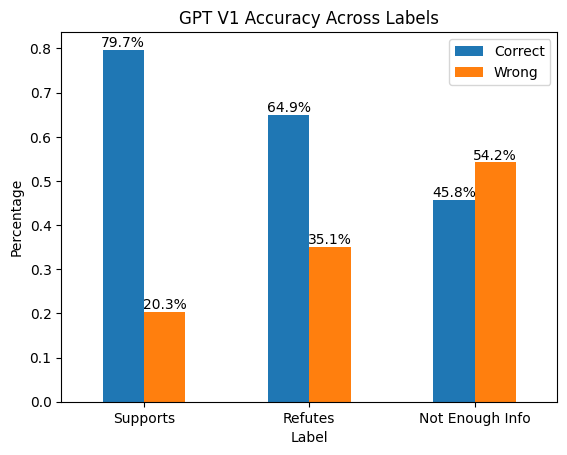

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Given data
support = df[df['golden_evi'] == "SUPPORTS"]
refutes = df[df['golden_evi'] == "REFUTES"]
notenough = df[df['golden_evi'] == "NOT ENOUGH INFO"]

# Calculate value counts for each category
support_counts = (support['FINAL_LABEL'] == support['golden_evi']).value_counts(normalize=True)
refutes_counts = (refutes['FINAL_LABEL'] == refutes['golden_evi']).value_counts(normalize=True)
notenough_counts = (notenough['FINAL_LABEL'] == notenough['golden_evi']).value_counts(normalize=True)

# Rename index values
support_counts.index = support_counts.index.map({True: 'Correct', False: 'Wrong'})
refutes_counts.index = refutes_counts.index.map({True: 'Correct', False: 'Wrong'})
notenough_counts.index = notenough_counts.index.map({True: 'Correct', False: 'Wrong'})

# Create a DataFrame for easy plotting
data = pd.DataFrame({'Supports': support_counts, 'Refutes': refutes_counts, 'Not Enough Info': notenough_counts}).T

# Plot the grouped bar chart
ax = data.plot(kind='bar', stacked=False)

# Set title and labels
ax.set_title('GPT V1 Accuracy Across Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Percentage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display percentages above the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1%}', (x + width/2, y + height), ha='center', va='bottom')

# Show the plot
plt.show()

## Test 2 (With different versions of Prompts)

In [1]:
import pandas as pd
# Read in full file
processedv2 = pd.read_csv("test_df.csv")
processedv2

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,temporal_claim,temporal_evidence,claim_numbers,evidence_numbers,all_entities_similarity,all_chunks_similarity,named_entities_similarity,temporal_similarity,count_claim_numbers,count_evidence_numbers
0,58219,Theodore Roosevelt was born in 1919.,REFUTES,REFUTES,['in 1919'],Theodore_Roosevelt,"In foreign policy , he focused on Central Amer...",Theodore Roosevelt was born in 1919.,"In foreign policy, he focused on Central Ameri...","['Theodore Roosevelt', '1919']",...,['1919'],[],[],[],0.090278,0.125000,0.091334,0.000000,0,0
1,50432,Bill Gates had a career at Microsoft after hel...,SUPPORTS,SUPPORTS,['after helping to found the company'],Bill_Gates,"In June 2006 , Gates announced that he would b...",Bill Gates had a career at Microsoft after hel...,"In June 2006, Gates announced that he would be...","['Bill Gates', 'Microsoft']",...,[],['june 2006'],[],[],0.500000,0.479960,0.500000,0.000000,0,0
2,58993,Snoop Dog's Doggystyle sold many copies in the...,SUPPORTS,NOT ENOUGH INFO,['in the first week of its release'],Doggystyle,Doggystyle is the debut studio album by Americ...,Snoop Dog s Doggystyle sold many copies in the...,Doggystyle is the debut studio album by Americ...,"['Snoop Dog s Doggystyle', 'the first week']",...,['the first week'],[],[],[],0.356250,0.329576,0.241071,0.000000,0,0
3,19794,"In 1899, FC Barcelona was formed.",SUPPORTS,NOT ENOUGH INFO,['In 1899'],FC_Barcelona,Barcelona was ranked first in the IFFHS Club W...,"In 1899, FC Barcelona was formed.",Barcelona was ranked first in the IFFHS Club W...,"['1899', 'Barcelona']",...,['1899'],"['2009', '2015', 'currently', '1997', '2012', ...",[],[],0.500000,0.312500,0.443249,0.386497,0,0
4,10805,Independence Day: Resurgence grossed millions ...,SUPPORTS,NOT ENOUGH INFO,['Independence Day'],Independence_Day_-LRB-1996_film-RRB-,The film grossed over 817.4 million worldwide ...,Independence Day: Resurgence grossed millions ...,"The film grossed over 817.4 million worldwide,...","['Independence Day:', 'millions']",...,['independence day'],"['1996', '1993']",[],"['817.4', 'million']",0.332309,0.153477,0.332309,0.136918,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,28241,The Jacksons aired on a weekday.,SUPPORTS,SUPPORTS,['on a weekday'],The_Jacksons_-LRB-TV_series-RRB-,The thirty minute Wednesday evening show began...,The Jacksons aired on a weekday.,The thirty minute Wednesday evening show began...,['weekday'],...,[],"['the thirty minute wednesday evening', '1976 ...",[],['12'],0.000000,0.093750,0.321221,0.000000,0,1
1283,61561,"Iris Murdoch died on February 8, 1999.",SUPPORTS,SUPPORTS,"['on February 8 , 1999']",Iris_Murdoch,Dame Jean Iris Murdoch LRB LSB ˈmɜrdɒk RSB 15 ...,"Iris Murdoch died on February 8, 1999.",Dame Jean Iris Murdoch LRB LSB ˈmɜrdɒk RSB 15 ...,"['Iris Murdoch', 'February 8, 1999']",...,['february 8 1999'],['15 july 1919 8 february 1999'],[],['8'],0.500000,0.347619,0.580235,1.000000,0,1
1284,41237,"In the 1960's, George Tuska worked on Iron Man...",SUPPORTS,NOT ENOUGH INFO,"[""In the 1960 's""]",Iron_Man,The character made his first appearance in Tal...,"In the 1960 s, George Tuska worked on Iron Man...",The character made his first appearance in Tal...,"['1960', 'George Tuska', 'Iron Man']",...,['1960'],['march 1963'],[],['39'],0.108333,0.160461,0.273263,0.832981,0,1
1285,9697,Warm Leatherette is by an actress and it came ...,SUPPORTS,SUPPORTS,['in 1980'],Warm_Leatherette_-LRB-album-RRB-,Warm Leatherette is the fourth studio album by...,Warm Leatherette is by an actress and it came ...,Warm Leatherette is the fourth studio album by...,['1980'],...,['1980'],['9 may 1980'],[],[],0.000000,0.352722,1.000000,1.000000,0,0


In [3]:
# Api calls were made in batches to prevent overloading
import pandas as pd
import requests
import json

def call_openai_api(row):
    claim = row["processed_claim_some_punctuation"]
    evidence = row["processed_evidence_some_punctuation"]
    payload = {
        "claim": claim,
        "evidence": evidence
    }
    print(claim)
    print(evidence)
    try:
        response = requests.post("https://fyp-gpt-wr6verfzva-as.a.run.app", json=payload)
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(response)
            print(f"Request failed with status code {response.status_code}")
    except Exception as e:
        print(f"Request failed with exception {e}")
    return None

df = processedv2

# Call the OpenAI API for each row and store the results in a new column called 'openai_results'
df['openai_results'] = df.apply(call_openai_api, axis=1)

# Filter out the rows where the API call failed
df = df[df['openai_results'].notna()]

# Ignore the column labels, as they were generated in the wrong order, but the response is correct
# Create new columns in the dataframe for each field in the JSON response
df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic', 'claim_temporal', 'evidence_temporal', 'relevant_evidence']] = df['openai_results'].apply(pd.Series)
df

Theodore Roosevelt was born in 1919.
In foreign policy, he focused on Central America, where he began construction of the Panama Canal.
Bill Gates had a career at Microsoft after helping to found the company.
In June 2006, Gates announced that he would be transitioning from full time work at Microsoft to part time work and full time work at the Bill Melinda Gates Foundation.
Snoop Dog s Doggystyle sold many copies in the first week of its release.
Doggystyle is the debut studio album by American rapper Snoop Doggy Dogg.
In 1899, FC Barcelona was formed.
Barcelona was ranked first in the IFFHS Club World Ranking for 1997, 2009, 2011, 2012 and 2015 and currently occupies the third position on the UEFA club rankings.
Independence Day: Resurgence grossed millions worldwide.
The film grossed over 817.4 million worldwide, becoming the highest grossing film of 1996, and briefly, the second highest grossing film worldwide of all time behind 1993 s Jurassic Park.
The Dogs D Amour formed in 2017

/tmp/ipykernel_32/868986777.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic', 'claim_temporal', 'evidence_temporal', 'relevant_evidence']] = df['openai_results'].apply(pd.Series)
/tmp/ipykernel_32/868986777.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_just

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic,claim_temporal,evidence_temporal,relevant_evidence
0,58219,Theodore Roosevelt was born in 1919.,REFUTES,REFUTES,['in 1919'],Theodore_Roosevelt,"In foreign policy , he focused on Central Amer...",Theodore Roosevelt was born in 1919.,"In foreign policy, he focused on Central Ameri...","['Theodore Roosevelt', '1919']",...,[born in 1919],[],The evidence does not support the claim that T...,REFUTES,[],"The claim refers to Theodore Roosevelt, while ...",False,The evidence does not provide any information ...,NOT ENOUGH INFORMATION,Theodore Roosevelt's life and accomplishments
1,50432,Bill Gates had a career at Microsoft after hel...,SUPPORTS,SUPPORTS,['after helping to found the company'],Bill_Gates,"In June 2006 , Gates announced that he would b...",Bill Gates had a career at Microsoft after hel...,"In June 2006, Gates announced that he would be...","['Bill Gates', 'Microsoft']",...,[],[In June 2006],The evidence states that Gates transitioned fr...,SUPPORTS,[Gates announced that he would be transitionin...,"The evidence refers to Bill Gates, who is the ...",True,The evidence mentions a specific date in June ...,NOT ENOUGH INFO,Bill Gates' career at Microsoft
2,58993,Snoop Dog's Doggystyle sold many copies in the...,SUPPORTS,NOT ENOUGH INFO,['in the first week of its release'],Doggystyle,Doggystyle is the debut studio album by Americ...,Snoop Dog s Doggystyle sold many copies in the...,Doggystyle is the debut studio album by Americ...,"['Snoop Dog s Doggystyle', 'the first week']",...,[in the first week of its release],[],The evidence confirms that Doggystyle is Snoop...,SUPPORTS,[Doggystyle is the debut studio album by Ameri...,The claim and evidence both refer to Snoop Dog...,True,The evidence does not provide an explicit temp...,SUPPORTS,Snoop Dogg's album Doggystyle
3,19794,"In 1899, FC Barcelona was formed.",SUPPORTS,NOT ENOUGH INFO,['In 1899'],FC_Barcelona,Barcelona was ranked first in the IFFHS Club W...,"In 1899, FC Barcelona was formed.",Barcelona was ranked first in the IFFHS Club W...,"['1899', 'Barcelona']",...,[In 1899],"[1997, 2009, 2011, 2012, 2015]",The evidence provides information about Barcel...,NOT ENOUGH INFO,[],"The evidence refers to Barcelona, which is the...",True,"The evidence mentions specific years (1997, 20...",SUPPORTS,FC Barcelona
4,10805,Independence Day: Resurgence grossed millions ...,SUPPORTS,NOT ENOUGH INFO,['Independence Day'],Independence_Day_-LRB-1996_film-RRB-,The film grossed over 817.4 million worldwide ...,Independence Day: Resurgence grossed millions ...,"The film grossed over 817.4 million worldwide,...","['Independence Day:', 'millions']",...,[1996],[],The evidence provides information that support...,SUPPORTS,[The film grossed over 817.4 million worldwide],The claim and evidence both refer to the same ...,True,The evidence does not provide any temporal inf...,NOT ENOUGH INFO,Box Office Performance of Independence Day: Re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,28241,The Jacksons aired on a weekday.,SUPPORTS,SUPPORTS,['on a weekday'],The_Jacksons_-LRB-TV_series-RRB-,The thirty minute Wednesday evening show began...,The Jacksons aired on a weekday.,The thirty minute Wednesday evening show began...,['weekday'],...,[on a weekday],"[Wednesday evening, summer 1976, 1976 1977 sea...",The evidence states that 'The Jacksons' show a...,SUPPORTS,[The thirty minute Wednesday evening show bega...,Both the claim and evidence refer to 'The Jack...,True,The evidence explicitly states that the show a...,SUPPORTS,The Jacksons TV show
1283,61561,"Iris Murdoch died on February 8, 1999.",SUPPORTS,SUPPORTS,"['on February 8 , 1999']",Iris_Murdoch,Dame J

In [4]:
df.to_csv("GPTV2PromptsResults.csv", index=False)

In [1]:
import pandas as pd
df = pd.read_csv("GPTV2PromptsResults.csv")
df

,id,claim,label,golden_evi,claim_temporal_arguments,evidence_title,evidence_content,processed_claim_some_punctuation,processed_evidence_some_punctuation,claim_named_entities,...,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic,claim_temporal,evidence_temporal,relevant_evidence
0,58219,Theodore Roosevelt was born in 1919.,REFUTES,REFUTES,['in 1919'],Theodore_Roosevelt,"In foreign policy , he focused on Central Amer...",Theodore Roosevelt was born in 1919.,"In foreign policy, he focused on Central Ameri...","['Theodore Roosevelt', '1919']",...,['born in 1919'],[],The evidence does not support the claim that T...,REFUTES,[],"The claim refers to Theodore Roosevelt, while ...",False,The evidence does not provide any information ...,NOT ENOUGH INFORMATION,Theodore Roosevelt's life and accomplishments
1,50432,Bill Gates had a career at Microsoft after hel...,SUPPORTS,SUPPORTS,['after helping to found the company'],Bill_Gates,"In June 2006 , Gates announced that he would b...",Bill Gates had a career at Microsoft after hel...,"In June 2006, Gates announced that he would be...","['Bill Gates', 'Microsoft']",...,[],['In June 2006'],The evidence states that Gates transitioned fr...,SUPPORTS,['Gates announced that he would be transitioni...,"The evidence refers to Bill Gates, who is the ...",True,The evidence mentions a specific date in June ...,NOT ENOUGH INFO,Bill Gates' career at Microsoft
2,58993,Snoop Dog's Doggystyle sold many copies in the...,SUPPORTS,NOT ENOUGH INFO,['in the first week of its release'],Doggystyle,Doggystyle is the debut studio album by Americ...,Snoop Dog s Doggystyle sold many copies in the...,Doggystyle is the debut studio album by Americ...,"['Snoop Dog s Doggystyle', 'the first week']",...,['in the first week of its release'],[],The evidence confirms that Doggystyle is Snoop...,SUPPORTS,['Doggystyle is the debut studio album by Amer...,The claim and evidence both refer to Snoop Dog...,True,The evidence does not provide an explicit temp...,SUPPORTS,Snoop Dogg's album Doggystyle
3,19794,"In 1899, FC Barcelona was formed.",SUPPORTS,NOT ENOUGH INFO,['In 1899'],FC_Barcelona,Barcelona was ranked first in the IFFHS Club W...,"In 1899, FC Barcelona was formed.",Barcelona was ranked first in the IFFHS Club W...,"['1899', 'Barcelona']",...,['In 1899'],"['1997', '2009', '2011', '2012', '2015']",The evidence provides information about Barcel...,NOT ENOUGH INFO,[],"The evidence refers to Barcelona, which is the...",True,"The evidence mentions specific years (1997, 20...",SUPPORTS,FC Barcelona
4,10805,Independence Day: Resurgence grossed millions ...,SUPPORTS,NOT ENOUGH INFO,['Independence Day'],Independence_Day_-LRB-1996_film-RRB-,The film grossed over 817.4 million worldwide ...,Independence Day: Resurgence grossed millions ...,"The film grossed over 817.4 million worldwide,...","['Independence Day:', 'millions']",...,['1996'],[],The evidence provides information that support...,SUPPORTS,['The film grossed over 817.4 million worldwide'],The claim and evidence both refer to the same ...,True,The evidence does not provide any temporal inf...,NOT ENOUGH INFO,Box Office Performance of Independence Day: Re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,28241,The Jacksons aired on a weekday.,SUPPORTS,SUPPORTS,['on a weekday'],The_Jacksons_-LRB-TV_series-RRB-,The thirty minute Wednesday evening show began...,The Jacksons aired on a weekday.,The thirty minute Wednesday evening show began...,['weekday'],...,['on a weekday'],"['Wednesday evening', 'summer 1976', '1976 197...",The evidence states that 'The Jacksons' show a...,SUPPORTS,['The thirty minute Wednesday evening show beg...,Both the claim and evidence refer to 'The Jack...,True,The evidence explicitly states that the show a...,SUPPORTS,The Jacksons TV show
1279,61561,"Iris Murdoch died on February 8, 1999.",SUPPORTS,SUPPORTS,"['on February 8 , 199

In [38]:
# Raw accuracy looking at just the general facts justification label
(df['general_facts_justification'] == df['golden_evi']).value_counts()

True     726
False    557
dtype: int64

In [39]:
726/(726+557)

0.5658612626656274

In [40]:
# Raw accuracy looking at just the temporal facts justification label
(df['evidence_temporal'] == df['golden_evi']).value_counts()
    

False    670
True     613
dtype: int64

In [41]:
613 / (613 + 670)

0.47778643803585347

In [2]:
df['FINAL_LABEL'] = df.apply(lambda row: 'SUPPORTS' if (row['general_facts_justification'] == "SUPPORTS" and  row['evidence_temporal'] == "SUPPORTS") else 'REFUTES' if row['evidence_temporal'] == "REFUTES" or row['general_facts_justification'] == "REFUTES" else 'NOT ENOUGH INFO', axis=1)
df['FINAL_LABEL'].value_counts()

SUPPORTS           537
REFUTES            452
NOT ENOUGH INFO    294
Name: FINAL_LABEL, dtype: int64

In [3]:
# Raw accuracy looking at just the temporal facts justification label
(df['FINAL_LABEL'] == df['golden_evi']).value_counts()
    

True     851
False    432
dtype: int64

In [44]:
851/(851 + 432)

0.6632891660171473

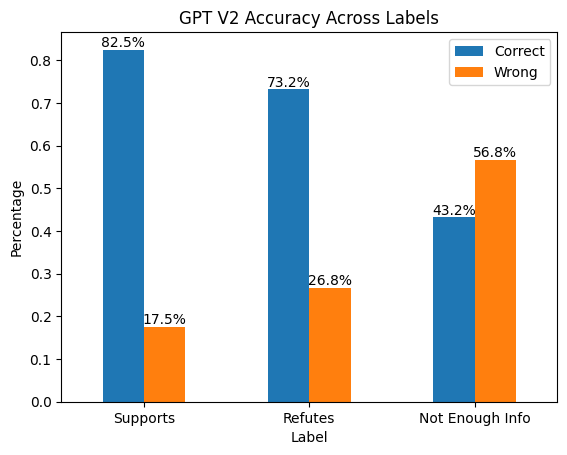

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Given data
support = df[df['golden_evi'] == "SUPPORTS"]
refutes = df[df['golden_evi'] == "REFUTES"]
notenough = df[df['golden_evi'] == "NOT ENOUGH INFO"]

# Calculate value counts for each category
support_counts = (support['FINAL_LABEL'] == support['golden_evi']).value_counts(normalize=True)
refutes_counts = (refutes['FINAL_LABEL'] == refutes['golden_evi']).value_counts(normalize=True)
notenough_counts = (notenough['FINAL_LABEL'] == notenough['golden_evi']).value_counts(normalize=True)

# Rename index values
support_counts.index = support_counts.index.map({True: 'Correct', False: 'Wrong'})
refutes_counts.index = refutes_counts.index.map({True: 'Correct', False: 'Wrong'})
notenough_counts.index = notenough_counts.index.map({True: 'Correct', False: 'Wrong'})

# Create a DataFrame for easy plotting
data = pd.DataFrame({'Supports': support_counts, 'Refutes': refutes_counts, 'Not Enough Info': notenough_counts}).T

# Plot the grouped bar chart
ax = data.plot(kind='bar', stacked=False)

# Set title and labels
ax.set_title('GPT V2 Accuracy Across Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Percentage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Display percentages above the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1%}', (x + width/2, y + height), ha='center', va='bottom')

# Show the plot
plt.show()

## Comparing GPT with XGBoost

In [5]:
df['tallies'] = (df['FINAL_LABEL'] == df['golden_evi'])

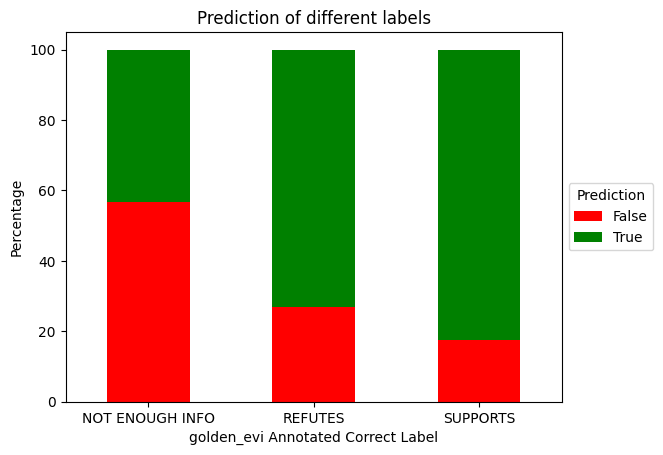

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by class and count the number of true and false flags
counts = df.groupby('golden_evi')['tallies'].value_counts(normalize=True) * 100

# Reshape the results into a dataframe
counts = counts.unstack()

# Create a stacked bar chart
colors = ['red', 'green']
counts.plot(kind='bar', stacked=True, color = colors)

# Add labels and title
plt.title('Prediction of different labels')
plt.xlabel('golden_evi Annotated Correct Label')
plt.ylabel('Percentage')
plt.legend(title='Prediction', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

# Show the plot
plt.show()

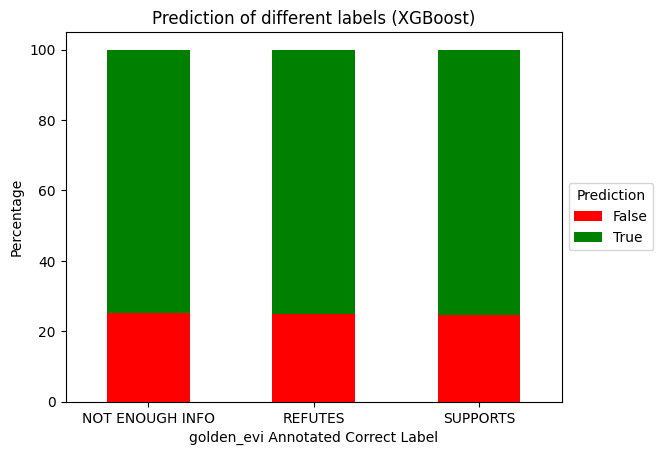

In [21]:
# Lets load in XGBoost prediction to do some analysis
testdf = pd.read_csv("test_df.csv")
xgboost = pd.read_csv("/notebooks/xgboost_final_predictions.csv")
xgboost['golden_evi'] = testdf['golden_evi']
xgboost['claim'] = testdf['processed_claim_some_punctuation']
xgboost['evidence'] = testdf['processed_evidence_some_punctuation']
# Define a mapping from integer labels to string labels
label_map = {0: "NOT ENOUGH INFO", 1: "REFUTES", 2: "SUPPORTS"}
# Apply the label mapping 
xgboost['xgboostpred'] = xgboost['xgboostpred'].apply(lambda x: label_map[x])
xgboost['tallies'] = (xgboost['xgboostpred'] == xgboost['golden_evi'])

import pandas as pd
import matplotlib.pyplot as plt

# Group by class and count the number of true and false flags
counts = xgboost.groupby('golden_evi')['tallies'].value_counts(normalize=True) * 100

# Reshape the results into a dataframe
counts = counts.unstack()

# Create a stacked bar chart
colors = ['red', 'green']
counts.plot(kind='bar', stacked=True, color = colors)

# Add labels and title
plt.title('Prediction of different labels (XGBoost)')
plt.xlabel('golden_evi Annotated Correct Label')
plt.ylabel('Percentage')
plt.legend(title='Prediction', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

# Show the plot
plt.show()

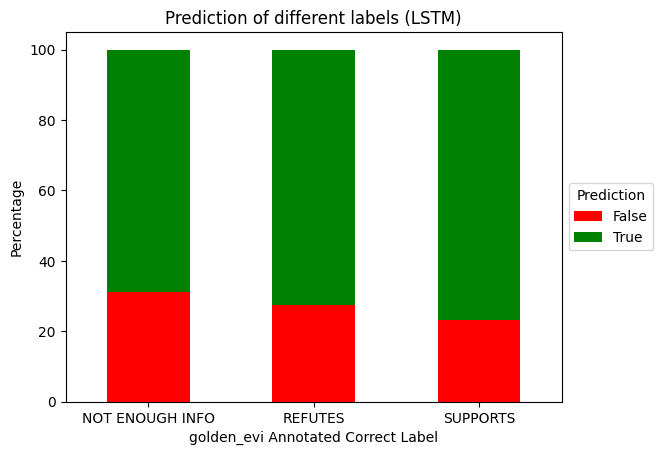

In [23]:
# Lets load in LSTM prediction to do some analysis
lstm = pd.read_csv("lstm_predictions.csv")
(lstm['lstm_predictions'] == lstm['golden_evi']).value_counts()
lstm['tallies'] = (lstm['lstm_predictions'] == lstm['golden_evi'])

import pandas as pd
import matplotlib.pyplot as plt

# Group by class and count the number of true and false flags
counts = lstm.groupby('golden_evi')['tallies'].value_counts(normalize=True) * 100

# Reshape the results into a dataframe
counts = counts.unstack()

# Create a stacked bar chart
colors = ['red', 'green']
counts.plot(kind='bar', stacked=True, color = colors)

# Add labels and title
plt.title('Prediction of different labels (LSTM)')
plt.xlabel('golden_evi Annotated Correct Label')
plt.ylabel('Percentage')
plt.legend(title='Prediction', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=0)

# Show the plot
plt.show()

### Annotation Review

We use GPT to get data for an annotation review.

In [1]:
import pandas as pd
df = pd.read_csv("annotation_review.csv")
df

,id,golden_evi,review_label,spacy_temporal,GPT_Temporal,claim_temporal_arguments,processed_claim_some_punctuation,processed_evidence_some_punctuation,temporal_claim
0,53654,SUPPORTS,NaN,NaN,NaN,['in 2008'],Big Bang won the Mnet Korean Music Festival s ...,After receiving the Artist of the Year award f...,['2008']
1,23723,SUPPORTS,NaN,NaN,NaN,"['June 12 , 1924']",George H. W. Bush was a Republican politician ...,"A member of the Republican Party, he was previ...",['june 12 1924']
2,47850,SUPPORTS,NaN,NaN,NaN,['On 28 December 1934'],"On 28 December 1934, Maggie Smith was born.","Dame Margaret Natalie Smith, LRB born 28 Decem...",['28 december 1934']
3,16738,SUPPORTS,NaN,NaN,NaN,['during World War II'],Gerd von Rundstedt was in France during World ...,"The Battle of France, also known as the Fall o...",[]
4,32315,SUPPORTS,NaN,NaN,NaN,['in 1948'],Scott Smith activist was named in 1948.,"Joseph Scott Smith LRB October 21, 1948 Februa...",['1948']
...,...,...,...,...,...,...,...,...,...
195,2932,SUPPORTS,NaN,NaN,NaN,"['on December 24 , 1974']","Ryan Seacrest was born on December 24, 1974.","Ryan John Seacrest LRB born December 24, 1974 ...",['december 24 1974']
196,45459,SUPPORTS,NaN,NaN,NaN,"['on March 23 , 1904']","Joan Crawford was born on March 23, 1904.",Joan Crawford LRB born Lucille Fay LeSueur ; M...,['march 23 1904']
197,26004,SUPPORTS,NaN,NaN,NaN,['at a time'],Pulp Fiction was released at a time.,"It was also nominated for seven Oscars, includ...",[]
198,51174,SUPPORTS,NaN,NaN,NaN,"['on Monday December 5 , 1938']","J. J. Cale was born on Monday December 5, 1938.","John Weldon J. J. Cale LRB December 5, 1938 Ju...",['monday december 5 1938']


In [3]:
# Api calls were made in batches to prevent overloading
import pandas as pd
import requests
import json

def call_openai_api(row):
    claim = row["processed_claim_some_punctuation"]
    evidence = row["processed_evidence_some_punctuation"]
    payload = {
        "claim": claim,
        "evidence": evidence
    }
    print(claim)
    print(evidence)
    try:
        response = requests.post("https://fyp-gpt-wr6verfzva-as.a.run.app", json=payload)
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            print(response)
            print(f"Request failed with status code {response.status_code}")
    except Exception as e:
        print(f"Request failed with exception {e}")
    return None

df = df

# Call the OpenAI API for each row and store the results in a new column called 'openai_results'
df['openai_results'] = df.apply(call_openai_api, axis=1)

# Filter out the rows where the API call failed
df = df[df['openai_results'].notna()]

# Ignore the column labels, as they were generated in the wrong order, but the response is correct
# Create new columns in the dataframe for each field in the JSON response
df[['same_entity_label', 'same_entity_justification', 'general_facts_label', 'general_facts_justification', 'time_label', 'time_justification', 'topic', 'claim_temporal', 'evidence_temporal', 'relevant_evidence']] = df['openai_results'].apply(pd.Series)
df

Big Bang won the Mnet Korean Music Festival s Artist of the Year award in 2008.
After receiving the Artist of the Year award from the 2008 Mnet Korean Music Festival, the group expanded their endeavors to Japan, releasing both their second Korean studio album, Remember, and their first Japanese album, Number 1, in the same year, and consequently winning three awards at the 9th MTV Video Music Awards Japan.
George H. W. Bush was a Republican politician born June 12, 1924.
A member of the Republican Party, he was previously a congressman, ambassador, and Director of Central Intelligence.
On 28 December 1934, Maggie Smith was born.
Dame Margaret Natalie Smith, LRB born 28 December 1934 RRB, known as Maggie Smith, is an English actress.
Gerd von Rundstedt was in France during World War II.
The Battle of France, also known as the Fall of France, was the German invasion of France and the Low Countries during the Second World War.
Scott Smith activist was named in 1948.
Joseph Scott Smith LRB

,id,golden_evi,review_label,spacy_temporal,GPT_Temporal,claim_temporal_arguments,processed_claim_some_punctuation,processed_evidence_some_punctuation,temporal_claim,openai_results,same_entity_label,same_entity_justification,general_facts_label,general_facts_justification,time_label,time_justification,topic,claim_temporal,evidence_temporal,relevant_evidence
0,53654,SUPPORTS,NaN,NaN,NaN,['in 2008'],Big Bang won the Mnet Korean Music Festival s ...,After receiving the Artist of the Year award f...,['2008'],"{'claim_temporal': ['in 2008'], 'evidence_temp...",[in 2008],"[from the 2008 Mnet Korean Music Festival, in ...",The evidence supports the claim by stating tha...,SUPPORTS,[After receiving the Artist of the Year award ...,Both the claim and evidence refer to the same ...,True,The evidence directly supports the claim by st...,SUPPORTS,Music
1,23723,SUPPORTS,NaN,NaN,NaN,"['June 12 , 1924']",George H. W. Bush was a Republican politician ...,"A member of the Republican Party, he was previ...",['june 12 1924'],"{'claim_temporal': ['June 12, 1924'], 'evidenc...","[June 12, 1924]",[],The evidence supports the claim that George H....,SUPPORTS,"[A member of the Republican Party, he was prev...",The evidence explicitly states that George H. ...,True,The evidence does not provide any information ...,NOT ENOUGH INFO,George H. W. Bush's political career
2,47850,SUPPORTS,NaN,NaN,NaN,['On 28 December 1934'],"On 28 December 1934, Maggie Smith was born.","Dame Margaret Natalie Smith, LRB born 28 Decem...",['28 december 1934'],"{'claim_temporal': ['On 28 December 1934'], 'e...",[On 28 December 1934],[born 28 December 1934],The evidence provides additional information t...,SUPPORTS,"[Dame Margaret Natalie Smith, known as Maggie ...",The evidence explicitly states that Dame Marga...,True,The evidence explicitly states that Maggie Smi...,SUPPORTS,Birthdate of Maggie Smith
3,16738,SUPPORTS,NaN,NaN,NaN,['during World War II'],Gerd von Rundstedt was in France during World ...,"The Battle of France, also known as the Fall o...",[],"{'claim_temporal': ['during World War II'], 'e...",[during World War II],[during the Second World War],The evidence supports the claim by providing i...,SUPPORTS,"[The Battle of France, also known as the Fall ...",The claim and evidence both refer to events th...,True,The evidence discusses the German invasion of ...,SUPPORTS,World War II in France
4,32315,SUPPORTS,NaN,NaN,NaN,['in 1948'],Scott Smith activist was named in 1948.,"Joseph Scott Smith LRB October 21, 1948 Februa...",['1948'],"{'claim_temporal': ['in 1948'], 'evidence_temp...",[in 1948],"[October 21, 1948, February 4, 1995]",The evidence confirms that Scott Smith was an ...,SUPPORTS,"[Joseph Scott Smith LRB October 21, 1948 Febru...",The evidence mentions a person named Joseph Sc...,True,The evidence provides a specific year (1948) t...,SUPPORTS,Scott Smith's activism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2932,SUPPORTS,NaN,NaN,NaN,"['on December 24 , 1974']","Ryan Seacrest was born on December 24, 1974.","Ryan John Seacrest LRB born December 24, 1974 ...",['december 24 1974'],"{'claim_temporal': ['December 24, 1974'], 'evi...","[December 24, 1974]","[December 24, 1974]",The evidence confirms that Ryan Seacrest is an...,SUPPORTS,"[Ryan John Seacrest (born December 24, 1974) i...",The evidence explicitly states that Ryan Seacr...,True,The evidence explicitly states that Ryan Seacr...,SUPPORTS,Ryan Seacrest's profession and birthdate
196,45459,SUPPORTS,NaN,NaN,NaN,"['on March 23 , 1904']","Joan Crawford was born on March 23, 1904.",Joan Crawford LRB born Lucille Fay LeSueur ; M...,['march 23 1904'],"{'claim_temporal': ['on March 23, 1904'], 'evi...","[on March 23, 1904]","[March 23, c. 1904, May 10, 1977]",The evidence supports the claim that Joan Craw...,SUPPORTS,[Joan Crawford LRB born Lucille Fay LeSueur ; ...,The evidence clearly refers to Joan Crawford a...,True,The evidence provides Joan Crawford's birthdat...

In [4]:
df.to_csv("annotation_review_gpt_generated.csv")

In [1]:
import pandas as pd

annotation = pd.read_csv("annotation_review.csv")
annotation.dropna(subset=['review_label'], inplace=True)
annotation

,id,golden_evi,Correct Label,Review Reason,review_label,spacy_temporal,GPT_Temporal,claim_temporal_arguments,processed_claim_some_punctuation,processed_evidence_some_punctuation,Spacy's temporal_claim,GPT's Temporal Extracts
0,53654,SUPPORTS,SUPPORTS,NaN,True,True,True,['in 2008'],Big Bang won the Mnet Korean Music Festival s ...,After receiving the Artist of the Year award f...,['2008'],['in 2008']
1,23723,SUPPORTS,NOT ENOUGH INFO,TEMPORAL,False,True,True,"['June 12 , 1924']",George H. W. Bush was a Republican politician ...,"A member of the Republican Party, he was previ...",['june 12 1924'],"['June 12, 1924']"
2,47850,SUPPORTS,SUPPORTS,NaN,True,True,True,['On 28 December 1934'],"On 28 December 1934, Maggie Smith was born.","Dame Margaret Natalie Smith, LRB born 28 Decem...",['28 december 1934'],['On 28 December 1934']
3,16738,SUPPORTS,NOT ENOUGH INFO,GENERAL,False,False,True,['during World War II'],Gerd von Rundstedt was in France during World ...,"The Battle of France, also known as the Fall o...",[],['during World War II']
4,32315,SUPPORTS,SUPPORTS,NaN,True,True,True,['in 1948'],Scott Smith activist was named in 1948.,"Joseph Scott Smith LRB October 21, 1948 Februa...",['1948'],['in 1948']
...,...,...,...,...,...,...,...,...,...,...,...,...
65,26354,SUPPORTS,NaN,NaN,True,True,True,['in the 15th century'],The Wars of the Roses took place in the 15th c...,The conflict lasted through many sporadic epis...,['the 15th century'],['in the 15th century']
66,25438,SUPPORTS,NaN,NaN,True,True,True,['in January of the year 2015'],Bernie Sanders was a member of the Senate in J...,Polls indicate that he is among the senators m...,['january of the year 2015'],['January of the year 2015']
67,42385,SUPPORTS,NaN,NaN,True,True,True,[],Diana Ross had many hits in her career.,"In 1993, the Guinness Book of World Records de...",[],[]
68,45710,SUPPORTS,NaN,NaN,True,True,True,"['August 30 , 1930']","Warren Buffett was born August 30, 1930.",Warren Edward Buffett LRB LSB Ààb åf·µªt RSB b...,['august 30 1930'],"['August 30, 1930']"


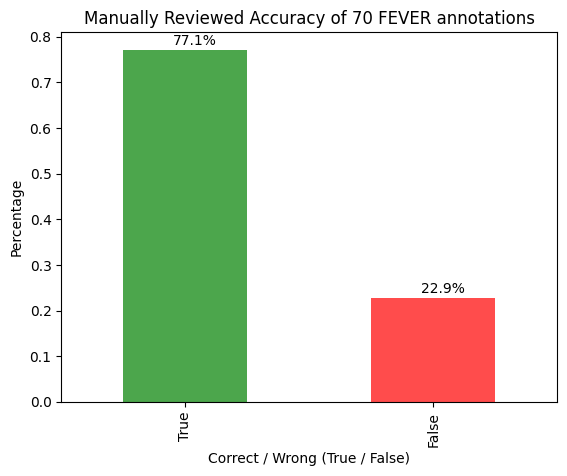

In [15]:
import matplotlib.pyplot as plt
# Calculate the proportion of True and False values
prop = annotation['review_label'].value_counts(normalize=True)

# Create the bar plot
ax = prop.plot(kind='bar', color=['green', 'red'], alpha=0.7)

# Add the percentage labels on top of the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.2, p.get_height()+0.01))
    
plt.title('Manually Reviewed Accuracy of 70 FEVER annotations')
plt.xlabel('Correct / Wrong (True / False)')
plt.ylabel('Percentage')

plt.show()

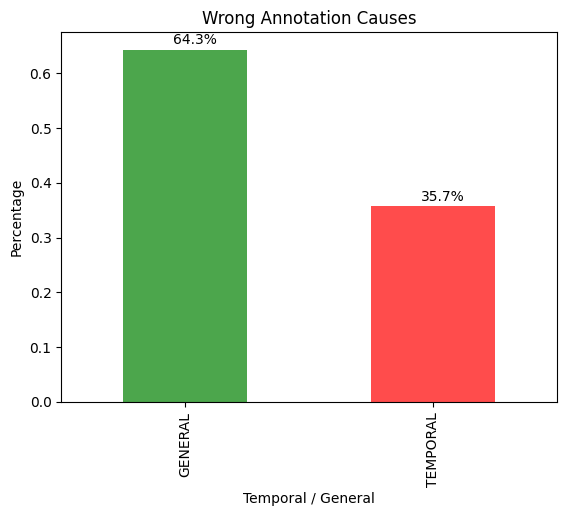

In [20]:
import matplotlib.pyplot as plt

# Drop rows with NaN values in the "Review Reason" column
data = annotation.dropna(subset=['Review Reason'])
prop = data['Review Reason'].value_counts(normalize=True)

# Create the bar plot
ax = prop.plot(kind='bar', color=['green', 'red'], alpha=0.7)

# Add the percentage labels on top of the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.2, p.get_height()+0.01))
    
plt.title('Wrong Annotation Causes')
plt.xlabel('Temporal / General')
plt.ylabel('Percentage')

plt.show()

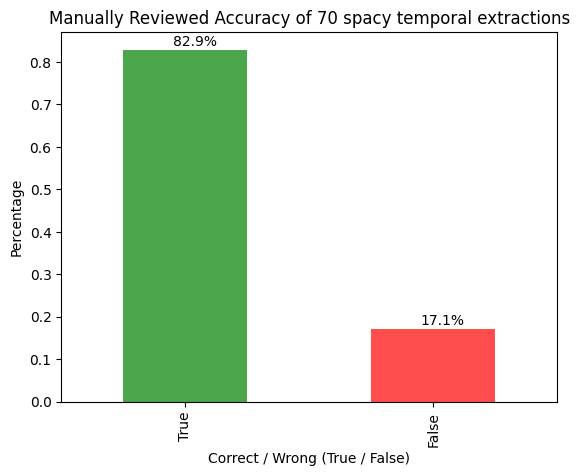

In [2]:
import matplotlib.pyplot as plt
# Calculate the proportion of True and False values
prop = annotation['spacy_temporal'].value_counts(normalize=True)

# Create the bar plot
ax = prop.plot(kind='bar', color=['green', 'red'], alpha=0.7)

# Add the percentage labels on top of the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.2, p.get_height()+0.01))
    
plt.title('Manually Reviewed Accuracy of 70 spacy temporal extractions')
plt.xlabel('Correct / Wrong (True / False)')
plt.ylabel('Percentage')

plt.show()

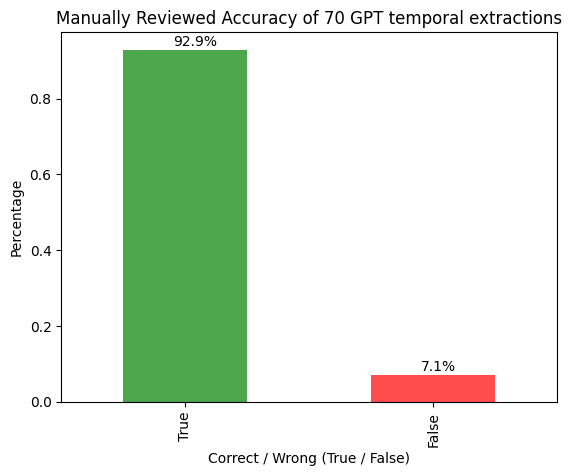

In [5]:
import matplotlib.pyplot as plt
# Calculate the proportion of True and False values
prop = annotation['GPT_Temporal'].value_counts(normalize=True)

# Create the bar plot
ax = prop.plot(kind='bar', color=['green', 'red'], alpha=0.7)

# Add the percentage labels on top of the bars
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.2, p.get_height()+0.01))
    
plt.title('Manually Reviewed Accuracy of 70 GPT temporal extractions')
plt.xlabel('Correct / Wrong (True / False)')
plt.ylabel('Percentage')

plt.show()